# Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ

## Путешествие по Спрингфилду. Постановка задачи.
Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал Симпсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персонажи менялись вместе с изменяющимися графическими технологиями и Гомер 2018 не очень похож на Гомера 1989. 

Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

Ссылка на задание и датасет:
https://www.kaggle.com/c/journey-springfield/overview

**Суть задачи** - обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда (multiclass classification). 
Обучающая и тестовая выборка состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа изображенного на ней (метки классов представлены в виде названий папок, в которых лежат картинки).

Оцениваемая метрика в результатах задания - f1-score (подробнее - ниже).

## Загрузка библиотек и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import copy

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torchvision import transforms, models

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
TRAIN_DIR = Path('../input/simpsons/train/simpsons_dataset')
TEST_DIR = Path('../input/simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

len(train_val_files), len(test_files)

(20933, 991)

In [3]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels, random_state=42)
len(np.unique(train_val_labels))

42

Всего для обучения и валидации предоставлено 20,9 тыс. картинок, разделяем в пропорции 75/25 %, стратифицируя по их классам. Всего потребуется классифицировать изображения на 42 класса, итоговое качество будет проверяться на тесте из 991 изображения.

In [4]:
train_labels = [path.parent.name for path in train_files]
sorted(list(zip(*np.unique(train_labels, return_counts=True))),
       key=lambda x: x[1])

[('lionel_hutz', 2),
 ('disco_stu', 6),
 ('troy_mcclure', 6),
 ('miss_hoover', 13),
 ('fat_tony', 20),
 ('gil', 20),
 ('otto_mann', 24),
 ('sideshow_mel', 30),
 ('agnes_skinner', 32),
 ('rainier_wolfcastle', 34),
 ('cletus_spuckler', 35),
 ('snake_jailbird', 41),
 ('professor_john_frink', 49),
 ('martin_prince', 53),
 ('patty_bouvier', 54),
 ('ralph_wiggum', 67),
 ('carl_carlson', 74),
 ('selma_bouvier', 77),
 ('barney_gumble', 80),
 ('groundskeeper_willie', 91),
 ('maggie_simpson', 96),
 ('waylon_smithers', 136),
 ('mayor_quimby', 185),
 ('lenny_leonard', 233),
 ('nelson_muntz', 269),
 ('edna_krabappel', 343),
 ('comic_book_guy', 352),
 ('kent_brockman', 373),
 ('apu_nahasapeemapetilon', 467),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('chief_wiggum', 739),
 ('milhouse_van_houten', 809),
 ('charles_montgomery_burns', 895),
 ('principal_skinner', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson', 1015),
 ('moe_szyslak'

Наблюдается существенный дисбаланс распределения данных по классам - в обучающей выборке по наименьшему классу (lionel_hutz) представлено всего 2 изображения, максимум данных присутствует по главному персонажу (homer_simpson) - 1684 изображения. Так же по многим классам для обучения имеется очень малое количество данных (примерно у половины всего от 2 до 100 изображений на класс).

В связи с этим:
1) Качество обучения модели при таком распределении данных будет неизбежно хуже, чем если бы выборка была более сбалансированной - модель будет "переучиваться" на наиболее часто попадаемых ей классах, ошибочно относя к ним на валидации тех персонажей, которые она реже "видела" при обучении. Распределение и в целом полноту присутствия всех классов на тестовой выборке для оценки эффективности модели мы, конечно, не знаем, но логично предположить, что соотношение там будет примерно таким же.

2) Особо остро встает вопрос метрики, с помощью которой будет итогово оцениваться эффективность модели - в конкурсе заявлена f1-score, однако не уточнен порядок ее расчета. Как минимум, имеется три вида расчета, каждый из которых применяется в зависимости от преследуемых целей модели:
- macro (среднеарифметически) - если необходимо минимизировать ошибки модели в каждом из классов, при этом модели одинаково важно правильно определить как незначительного персонажа lionel_hutz, так и главного героя homer_simpson,
- weighted (средневзвешенно) - более мягкий вариант предыдущего вида - модели все так же важно не ошибаться в каждом из классов, однако теперь степень важности уже взвешивается на величину представленного класса,
- micro ("обобщенно") - учитывает общее количество верных предсказаний и ошибок по датасету, и соответствует показателю точности accuracy. При данном расчете, к примеру, если присутствует всего два класса с распределением 1/99 %, модель может просто тривиально выдавать одни и те же предсказания наибольшего класса (naive model), и данный показатель составит 0,99.

В зависимости от целей предсказательной модели - нам важно не ошибаться ни в одном классе (возможно ошибочно относя "с запасом", например, часть картинок Гомера Симпсона к наименее представленному классу) или в целом максимизировать корректные предсказания ("жертвуя" наименее представленными классами в пользу наиболее часто встречающихся) - будет отличаться порядок расчета метрики и, соответственно, подход к решению проблемы дисбаланса представленных классов:
- в первом случае (macro) - следует обучать модель с подачей батчей с как можно более равным количеством изображений для каждого класса, чтобы модель равномерно училась распознавать каждый из классов - в этом может помочь WeightedRandomSampler
- во втором (micro/weighted) - обучение модели следует проводить примерно в тех же пропорциях классов, в каких они и встречаются "в жизни" (т.е. на тестовой выборке), ну или вообще рандомно, однако все же в целях минимизации общего количества ошибок обучающую выборку следует дополнить изображениями наименее представленных классов. Здесь так же вижу два пути - либо достать новых картинок "из природы", либо просто искусственно раскопировать все те же изображения из обучающей выборки - их "одинаковость" в дальнейшем будет нивелирована рандомной аугментацией перед подачей в модель на обучение (т.е. все же это будут не одни и те же изображения).

Забегая вперед - эмпирически пришел к выводу, что оценка на тесте производится с использованием метрики micro f1, или просто accuracy, соответственно, просто пошел по второму пути - т.к. при постановке задания не было прямо указано на разрешение добавить в датасет новые изображения, я решил пойти на искусственное расширение датасета (копирование+аугментация).

In [5]:
# Копирование изображений для персонажей, по которым в датасете менее 100 картинок

char_imgs = {character: [] for character in np.unique(train_labels)}

for character, counts in zip(*np.unique(train_labels, return_counts=True)):
    char_imgs[character].extend([img for img in train_files if img.parent.name == character])
    if len(char_imgs[character]) < 100:
        for i in iter(char_imgs[character]):
            char_imgs[character].append(i)
            if len(char_imgs[character]) == 100:
                break

In [6]:
train_files = [img for imgs in char_imgs.values() for img in imgs]

# теперь у каждого из классов будет как минимум по 100 изображений
len(char_imgs['lionel_hutz'])

100

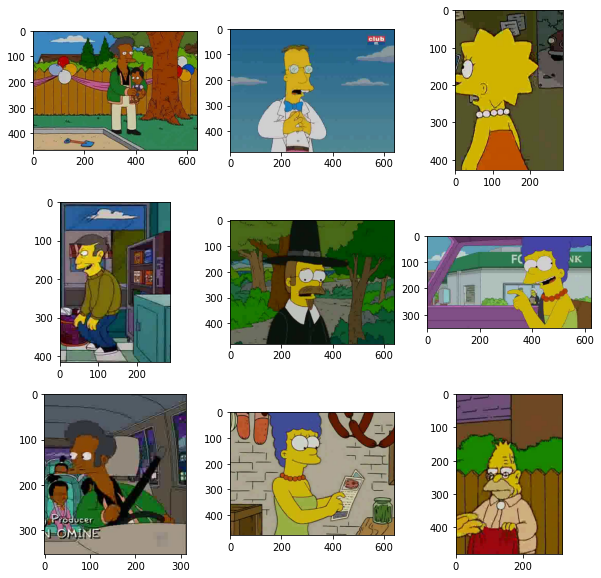

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax in axes.flatten():
    ax.imshow(Image.open(train_files[np.random.randint(len(train_files))]))
    

Как видно, изображения сильно разнятся не только по входному размеру, но и по смысловой составляющей - у классифицируемых объектов разное расположение на картинке, поза, центрирование и проч., кроме того изображения существенно различаются по качеству - видимо, в связи с тем, что скриншоты собирались по сериям из различных сезонов разных годов выпуска, резкость картинки и цвета так же достаточно сильно отличаются. Все это усложняет задачу для модели - один и тот же персонаж на разных скриншотах из разных сезонов может изменяться до неузнаваемости.

В том числе с данными проблемами, помимо трансформации раскопированных картинок, будет бороться аугментация.

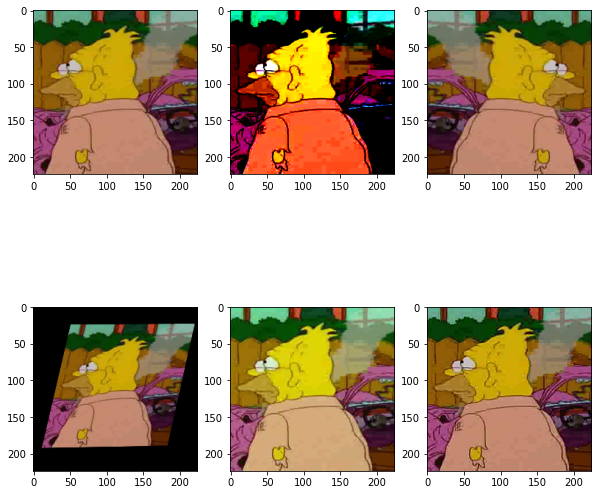

In [9]:
plt.figure(figsize=(10,10))

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)) 
            ])

trans_ex = [transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(1),
            transforms.RandomPerspective(0.5, 1),
            transforms.RandomAutocontrast(1),
            transforms.RandomAdjustSharpness(2, 1)]

img = Image.open(train_files[0])
plt.subplot(2,3,1)
plt.imshow(transform(img).numpy().transpose((1, 2, 0)))

for i in range(len(trans_ex)):
    plt.subplot(2,3,i+2)
    plt.imshow(trans_ex[i](transform(img)).numpy().transpose((1, 2, 0)))   

В предобработке будут использованы следующие трансформации:
- обрезка изображения до размера 224х224 и нормализация цветов под стандарты архитектур сетей, обученных на датасете imagenet (первое изображение выше - отмасштабированный оригинал, второе - эффект нормализации)
- рандомно применяемые к датасету трансформации - соответственно по очередности с третьего: отражение по горизонтали, наклоны/пространственные искажения, изменение контрастности и резкости цвета.

## Задание классов и функций для обучения

In [7]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок,
    превращает в тензоры и трансформирует
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = {'test_val': 
                     transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))]),
                     'train': 
                     transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomPerspective(),
                        transforms.RandomAutocontrast(),
                        transforms.RandomAdjustSharpness(2)])}
                        
        x = self.load_sample(self.files[index])
        
        if self.mode == 'test':
            return transform['test_val'](x)
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            if self.mode == 'val':
                return transform['test_val'](x), y
            else:
                return transform['train'](x), y   
    

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    scheduler.step()
    
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    
    return val_loss, val_acc

In [13]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.8)
        criterion = nn.CrossEntropyLoss()
        best_acc = 0

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = copy.deepcopy(model.state_dict())
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, best_model

Выше изложены итоговые версии функций для получения конечной наиболее эффективной модели нейросети. В процессе подбора наиболее оптимальных параметров обучения были использованы следующие модели:
- простая baseline модель из 5 convolution-слоев с пулингами и линейным выходом на 2х эпохах обучения со стандартным Adam оптимизатором без применеия scheduler - итоговая accuracy 0,64
- проверка на данной модели воздействия различных видов аугментации - к вышеуказанным были добавлены ColorJitter (изменение цветов), RandomResizedCrop (случайное центрирование), RandomRotation (случайные повороты) и проч. - использование всех преобразований вместе существенно ухудшило обучение модели, она практически перестала обучаться, т.к. исходные изображения слишком сильно менялись "до неузнаваемости" - accuracy не поднималась выше 0,15.
- путем подбора различных комбинаций было установлен наиболее оптимальный набор аугментаций, который и был использован в последующих моделях - accuracy baseline модели улучшилось до 0,67
- были использованы следующие архитектуры нейросетей (с "заморозкой" предобученных параметров feature extraction блоков - были заменены на обучение только блоки-классификаторы):

In [14]:
# функция для автоматизации подсчета итоговой метрики

def f1(model):
    with torch.no_grad():
        logits = []
    
        for inputs, _ in val_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=1)
    
    score = f1_score(val_true, preds, average='micro')
    
    return score

In [15]:
vgg_model = models.vgg16(pretrained=False)
vgg_model.features.add_module('(31)', nn.BatchNorm2d(512))
n_classes = len(np.unique(train_val_labels))
vgg_model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(4096),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=n_classes, bias=True))

vgg_model.load_state_dict(torch.load('../input/model-vgg16/vgg16_model_weights.pth'))
vgg_model.to(DEVICE)

val_dataset = SimpsonsDataset(val_files, mode='val')
val_loader = DataLoader(val_dataset,  shuffle=False, batch_size=64)
val_true = val_dataset.label_encoder.transform(val_dataset.labels)

f1(vgg_model)

0.7896446312571646

Модель VGG-16 с добавлением доп. слоя с батч-нормализацией к концу блока признаков и еще одного в классификатор до дропаутов, обучение на 7 эпохах - итоговая точность на валидации 0,79.

In [16]:
resnet = models.resnet152(False)
resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=2048, bias=True),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(2048),
                         nn.Dropout(p=0.5, inplace=False),
                         nn.Linear(in_features=2048, out_features=1024, bias=True),
                         nn.ReLU(inplace=True),
                         nn.Dropout(p=0.5, inplace=False),
                         nn.Linear(in_features=1024, out_features=n_classes, bias=True))

resnet.load_state_dict(torch.load('../input/model-resnet/resnet_model_weights.pth'))
resnet.to(DEVICE)

f1(resnet)

0.7181887657623233

Модель resnet152 с классификатором, аналогичным предыдущему, обучение на 10 эпохах - 0,72. Относительно низкие значения метрики, вероятно, объясняются слишком жестким параметром scheduler - изначально использовался с параметром gamma 0,5, из-за чего шаги оптимизации слишком быстро уменьшались и модель существенно замедляла темп обучения.

In [17]:
dense_model = models.densenet201()
dense_model.classifier = nn.Linear(in_features=1920, out_features=n_classes)

dense_model.load_state_dict(torch.load('../input/dense-model/dense_model_weights_3.pth'))
dense_model.to(DEVICE)
print(f1(dense_model))

0.838746656476882


Модель densenet120, точность 0,84 - обучалась итеративно три раза по 10 эпох, в обучении использовался scheduler с параметром гамма 0,5 (при каждой итерации инстанцировался заново)

In [18]:
inc_model = models.inception_v3(False)
inc_model.fc = nn.Linear(in_features=2048, out_features=42, bias=True)
inc_model.aux_logits = False

inc_model.load_state_dict(torch.load('../input/incept/inc_model_weights.pth'))
inc_model.to(DEVICE)

RESCALE_SIZE = 299
val_dataset = SimpsonsDataset(val_files, mode='val')
val_loader = DataLoader(val_dataset,  shuffle=False, batch_size=64)

print(f1(inc_model))

0.42701566679403896


Inseption_v3 - 10 эпох, без scheduler, итоговая метрика наихудшая из всех - 0,43.

Так как предобученные модели не показывали желаемую производительность, было принято решение обучать нейросеть полностью с нуля. Под обучение была выбрана архитектура модели densenet121 - она быстрее обучается, а так же предобученная модель данной архитектуры показывала наиболее высокие результаты по сравнению со всеми остальными.

Данная модель обучалась тремя итерациями по 10 эпох - один раз без использования scheduler и два раза с его использованием с установкой более мягкого параметра гамма 0,8 (скедулер экспоненциальный), что позволило первоначально обучать модель с более высокой скоростью без существенного замедления шагов оптимизации, и далее на последующих итерациях применять замедление шагов для наиболее эффективного нахождения минимума функции потерь.

In [23]:
dense_scratch = models.densenet121()
dense_scratch.classifier = nn.Linear(in_features=1024, out_features=42, bias=True)

dense_scratch.load_state_dict(torch.load('../input/dense-scratch/ds_model_weights.pth'))
dense_scratch.to(DEVICE)

RESCALE_SIZE = 224
val_dataset = SimpsonsDataset(val_files, mode='val')
val_loader = DataLoader(val_dataset,  shuffle=False, batch_size=64)

print(f1(dense_scratch))

dense_scratch.load_state_dict(torch.load('../input/dense-scratch/ds_model_weights_2.pth'))
print(f1(dense_scratch))
dense_scratch.load_state_dict(torch.load('../input/dense-scratch/ds_model_weights_3.pth'))
print(f1(dense_scratch))

0.8859380970576997
0.9434466946885747
0.9445930454719144


По итогам третьей итерации точность на валидации составила 0,94.
Расчет предикта на тесте и загрузка на каггл:

In [24]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(dense_scratch, test_loader)

label_encoder = val_dataset.label_encoder
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('./simp_sub.csv', index=False)

**Итоговый скор на каггле - 0.98512, ник на лидерборде - Marat_Akhmadeev_48825581**


## Разбор ошибок модели

In [18]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, _ in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

probs = predict(dense_scratch, val_loader)
preds = np.argmax(probs, axis=1)
val_true = label_encoder.transform(val_dataset.labels)

In [19]:
# количество изображений, на которых модель выдала высокую вероятность некорректного класса

len(np.where(np.all(np.c_[preds != val_true, np.max(probs, axis=1) > 0.9], axis=1))[0])

107

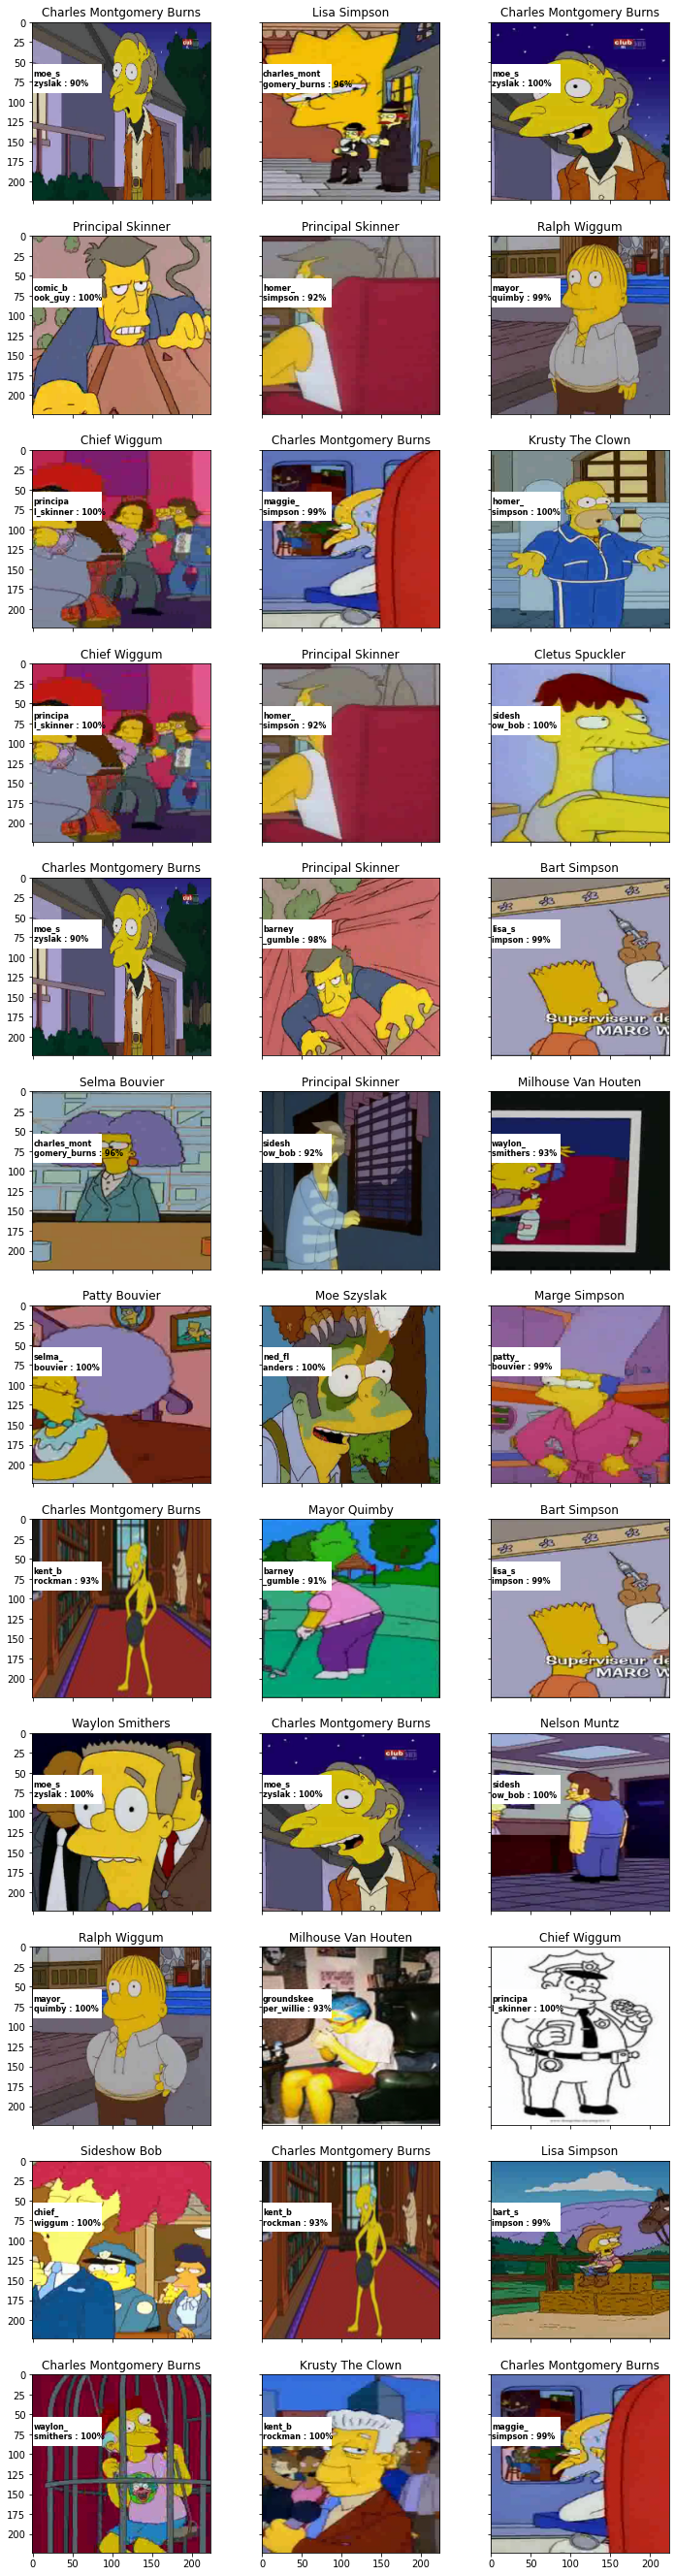

In [69]:
# функции для отрисовки "проблемных" изображений

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=12, ncols=3,figsize=(12, 48), \
                        sharey=True, sharex=True)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

for fig_x in ax.flatten():
    random_characters = np.random.choice(np.where(np.all(np.c_[preds != val_true,
                                                               np.max(probs, axis=1) > 0.9],
                                                         axis=1))[0])
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(dense_scratch, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Несколько изображений из 107 наиболее сложных для обученной модели - в заголовке корректный класс, надпись на картинке содержит предсказание модели с вероятностью отнесения. 

Как видно, некоторые картинки содержат достаточно непростые случаи - на них могут присутствовать определяемый объект в компании среди сразу многих нескольких персонажей, персонаж может быть изображен в нетипичной для него форме (присутствуют схематичные рисунки, а так же реальные фотографии людей в образе героев). 

Теоретически, такие случаи можно считать выбросами (задача модели все же классифицировать мультяшные персонажи), и при исключении их из тренировочной выборки итоговая эффективность модели может стать лучше.